In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
print("s")

s


In [0]:
import nltk 
import sys
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('indian')
from nltk.corpus import stopwords 
from nltk.corpus import indian
from nltk.tag import tnt
from nltk.tokenize import word_tokenize, sent_tokenize 
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
stop_words = set(stopwords.words('english')) 
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Input
from keras.models import Model
from keras import optimizers
from keras.layers import concatenate,CuDNNLSTM
from keras import initializers
from keras import backend as K
import random
sys.setrecursionlimit(12000)
from keras.layers import Dense, LSTM,Dropout, Activation,Bidirectional,Reshape,Permute,Multiply,Flatten,Lambda,Layer,TimeDistributed,CuDNNLSTM

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package indian to /root/nltk_data...
[nltk_data]   Package indian is already up-to-date!


Using TensorFlow backend.


In [0]:



'''
Breaking whole data into list of sentences
'''
def seperate_sentences(data):
    return sent_tokenize(data) 


def Sentence_to_POS(all_sentences):

    data=[]
    train_data = indian.tagged_sents('hindi.pos')
    tnt_pos_tagger = tnt.TnT()
    tnt_pos_tagger.train(train_data)

    for sentence in all_sentences: 
        one_sentence_pos = []
        '''
        Word tokenizers is used to find the words and punctuation in a string 
        '''  
#         wordsList = nltk.word_tokenize(sentence) 
        
        '''
        Removing stop words from wordList.
        ''' 
#         wordsList = [w for w in wordsList if not w in stop_words]  

        '''
        Using a Tagger. Which is part-of-speech tagger or POS-tagger.  
        '''

        tagged = (tnt_pos_tagger.tag(nltk.word_tokenize(sentence))) 
        for x in tagged:
            one_sentence_pos.append(x[1])
        data.append(one_sentence_pos)

    return data


def Fianl_X_and_Y(novel_POS,novel_label,number_of_sentenes_in_one):
    '''
    This funtion takes generates more data for training by breaking one novel into multiple novels
    with k number of sentences (number_of_sentenes_in_one) .we are ignoring some last sentences if they
    dont fit
    '''
    i=0
    X=[]
    Y=[]
    for novel in novel_POS:
        start = 0
        end = number_of_sentenes_in_one
        while(end<=len(novel)):
            X.append(novel[start:end])
            Y.append(novel_label[i])
            start=end
            end=end+number_of_sentenes_in_one
        i+=1
    return X,Y


def Get_X_and_Y_In_POS_Form(path_of_dataset_directory,number_of_sentences_in_one):
    '''
    this function takes the path of directory where the dataset is and returns the processed X and Y.
    The function calls will let u understand more the flow of code
    '''
#     all_files = os.listdir(path_of_dataset_directory)
    all_files = ['12ItrainR1.TXT','12ItrainR2.TXT','12ItrainO1.TXT','12ItrainS2.TXT','12ItrainS1.TXT','12ItrainU1.TXT','12ItrainU2.TXT','12ItrainV1.TXT','12ItrainW1.TXT']
    novel_POS=[]
    novel_label=[]
    file_number=1
    for filename in all_files:
        print(file_number,"/",len(all_files)," Done")
        file_number+=1
        full_path = '/content/gdrive/My Drive/hindidataset/'+filename
        with open(full_path, 'r') as f:
            data = f.read().replace('"\n"','').replace('\n',' ').replace('- ','')
            all_sentences = seperate_sentences(data)
            sentences_to_pos = Sentence_to_POS(all_sentences)
            novel_POS.append(sentences_to_pos)
            novel_label.append(filename[8])
    return Fianl_X_and_Y(novel_POS,novel_label,number_of_sentences_in_one)

def tag_to_index_dictionary(X):
    '''
    This function just creates a dictionary from the POS tags which we
    encountered in our dataset.As the network works with numbers so simple will make
    dictionary which stores the index of associated POS tag
    '''
    tag = set([])
    for doc in X:
        for sentence in doc:
            for word in sentence:
                tag.add(word)
    tag2index = {t: i + 1 for i, t in enumerate(list(tag))}
    tag2index['-PAD-'] = 0
    return tag2index

def convert_tag_to_sequence_numbers(X):
    tag2index = tag_to_index_dictionary(X)
    '''
    using the tag2index dictionary assign indexs to the POS tags in our data
    '''
    new_X=[]
    for doc in X:
        new_S = []
        for sentence in doc:
            new_W=[]
            for word in sentence:
                new_W.append(tag2index[word])
            new_S.append(new_W)
        new_X.append(new_S)
    return new_X


def pad_zeros_to_sequence(X,max_length):
    '''
    This function padds zeros to the sequences so as to make fixed sequences
    According to paper 15 is best value for max_length
    '''
    
    new_X=[]
    for doc in X:
        new_X.append(pad_sequences(doc, maxlen=max_length, padding='post'))
    return new_X

def Encode_Labels(Y):
    '''
    This fucntion encodes the labels i.e., assign numbers to the labels
    '''
    le = LabelEncoder()
    return le.fit_transform(Y)




In [0]:
print("Preprocessing Phase 1 : Fetching data")
print(".....................................")

X__,Y__ = Get_X_and_Y_In_POS_Form('dataset/three_author_dataset',100)

print("Preprocessing Phase 1 : Finished\n\n")
print(".....................................")

Preprocessing Phase 1 : Fetching data
.....................................
1 / 9  Done
2 / 9  Done
3 / 9  Done
4 / 9  Done
5 / 9  Done
6 / 9  Done
7 / 9  Done
8 / 9  Done
9 / 9  Done
Preprocessing Phase 1 : Finished


.....................................


NameError: ignored

In [0]:

X,Y=X__,Y__

In [0]:
np.unique(Y,return_counts=True)


(array(['O', 'R', 'S', 'U', 'V', 'W'], dtype='<U1'),
 array([ 1, 15,  7,  7, 11,  1]))

In [0]:
def Balance_Data(X,Y):
  MIN_VAL = min(np.unique(Y,return_counts=True)[1])+200
  A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W=0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
  X_data=[]
  for i in range(len(X)):
      if(Y[i]=='O' and A<MIN_VAL):
          X_data.append([X[i],Y[i]])
          A+=1
      elif(Y[i]=='R' and B<MIN_VAL):
          X_data.append([X[i],Y[i]])
          B+=1
      elif(Y[i]=='S' and C<MIN_VAL):
          X_data.append([X[i],Y[i]])
          C+=1

      elif(Y[i]=='U' and D<MIN_VAL):
          X_data.append([X[i],Y[i]])
          D+=1

      elif(Y[i]=='V' and E<MIN_VAL):
          X_data.append([X[i],Y[i]])
          E+=1

      elif(Y[i]=='W' and F<MIN_VAL):
          X_data.append([X[i],Y[i]])
          F+=1
    
  random.shuffle(X_data)
        
  new_X=[]
  new_Y=[]
  for m , n in X_data:
    new_X.append(m)
    new_Y.append(n)
    
  return new_X,new_Y

X,Y=Balance_Data(X,Y)

In [0]:
DICTIONARY_LENGTH = len(tag_to_index_dictionary(X))
MAX_LENGTH = 30
SENTENCES_IN_NOVEL=100

X = convert_tag_to_sequence_numbers(X)
X = pad_zeros_to_sequence(X,MAX_LENGTH)
X = np.array(X)
TOTAL_ROWS=X.shape[0]

In [0]:
real_X = []
for i in range(SENTENCES_IN_NOVEL):
    real_X.append(list())
for i in range(SENTENCES_IN_NOVEL):
    for j in range(TOTAL_ROWS):
        real_X[i].append(X[j][i])

X_train = []
for i in range(SENTENCES_IN_NOVEL):
    X_train.append(np.array(real_X[i]))



Y = Encode_Labels(Y) 
from tensorflow.keras.utils import to_categorical
y_binary = to_categorical(Y)


In [0]:
np.array(X_train).shape

(100, 42, 30)

In [0]:
from keras.engine.topology import Layer as LL
class Attention(LL):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        print(self.W_constraint)
        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        print(eij.shape,self.b.shape)

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [0]:
print("s")

s


In [0]:
from keras import  regularizers,constraints,initializers
model = Sequential() 

FIRST_LSTM =256
SECOND_LSTM=256
EMBEDD_VECTOR_LENGTH=128
outputs=[]
inputs_=[]
EMB = Embedding(DICTIONARY_LENGTH, EMBEDD_VECTOR_LENGTH, input_length=30)
BDR = Bidirectional(CuDNNLSTM(FIRST_LSTM,return_sequences=True),merge_mode='concat')
TDB = TimeDistributed(Dense(DICTIONARY_LENGTH+3))
for i in range(SENTENCES_IN_NOVEL):# SENTENCES_IN_NOVEL = 100
    if(i%10==0):
      print(i,"/",SENTENCES_IN_NOVEL)
    inputlayer = Input(shape=[MAX_LENGTH]) #MAX_LENGTH = 30 (30 words per sentence)
    inputs_.append(inputlayer)
    layer = EMB(inputlayer) # 50 is embedd vector size for each POS Tag
    layer =  BDR(layer)#output 100 because of bidirectonal concat
    layer =  Lambda( lambda x: K.sum(x, axis=1), input_shape=(30,2*FIRST_LSTM))(layer)
    outputs.append(layer)
    
merge_ = concatenate(outputs)
merge_ = Reshape((SENTENCES_IN_NOVEL, 2*FIRST_LSTM), input_shape=(SENTENCES_IN_NOVEL*(2*FIRST_LSTM),))(merge_)
merge_ = Bidirectional(CuDNNLSTM(SECOND_LSTM,return_sequences=True),merge_mode='concat')(merge_)
# merge_ = TimeDistributed(Dense(128))(merge_)

attention_mul = Attention(100)(merge_)#step_dimen =100
output = Dense(6, activation='softmax')(attention_mul)
/''
model = Model(inputs=inputs_,outputs=output)
model.summary()

0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
None
(?, 100) (100,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_101 (InputLayer)          (None, 30)           0                                            
__________________________________________________________________________________________________
input_102 (InputLayer)          (None, 30)           0                                            
__________________________________________________________________________________________________
input_103 (InputLayer)          (None, 30)           0                                            
__________________________________________________________________________________________________
input_104 (InputLayer)          (None, 30)           0                                            

In [0]:
 np.array([1,2,3,4,5,6]).reshape(2,3)

array([[1, 2, 3],
       [4, 5, 6]])

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Nadam(lr=0.001),
              metrics=['accuracy'])
history = model.fit(X_train,y_binary, epochs=100,validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 37 samples, validate on 5 samples
Epoch 1/100
37/37 [==============================] - 23s 625ms/step - loss: 1.8372 - acc: 0.2703 - val_loss: 2.2972 - val_acc: 0.2000
Epoch 2/100
37/37 [==============================] - 1s 28ms/step - loss: 1.7531 - acc: 0.3243 - val_loss: 2.6159 - val_acc: 0.0000e+00
Epoch 3/100
37/37 [==============================] - 1s 26ms/step - loss: 2.0149 - acc: 0.2162 - val_loss: 2.2234 - val_acc: 0.2000
Epoch 4/100
37/37 [==============================] - 1s 27ms/step - loss: 1.9717 - acc: 0.3243 - val_loss: 2.1100 - val_acc: 0.0000e+00
Epoch 5/100
37/37 [==============================] - 1s 27ms/step - loss: 1.4891 - acc: 0.4324 - val_loss: 1.4464 - val_acc: 0.2000
Epoch 6/100
37/37 [==============================] - 1s 27ms/step - loss: 1.3079 - acc: 0.5135 - val_loss: 1.2722 - val_acc: 0.4000
Epoch 7/100
37/37 [==============================] - 1s 27ms/step - loss: 1.4079 - acc: 0.3514 - val_loss: 

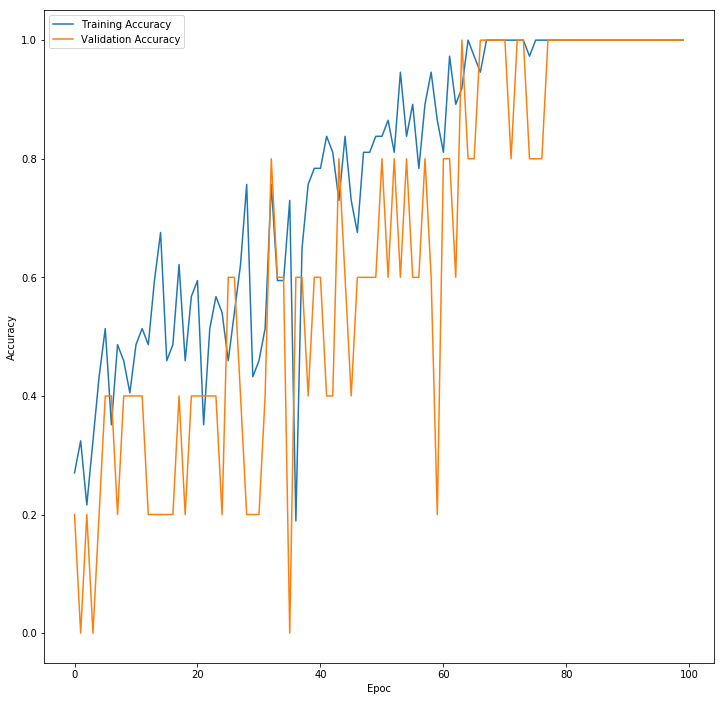

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
hist = pd.DataFrame(history.history)
plt.figure(figsize=(12,12))
plt.plot(hist["acc"],label="Training Accuracy")
plt.plot(hist["val_acc"],label="Validation Accuracy")
plt.xlabel("Epoc")
plt.ylabel("Accuracy")
plt.legend() 
plt.show()